Summary of Steps:

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with
cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
PATH = ""

In [3]:
import simple_binary_image_classifier as bc

D:\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
model1000 = bc.BinaryClassifier(PATH)

Use lr_find() to find highest learning rate where loss is still clearly improving

In [5]:
model1000.learning_rate_finder()

 52%|████████████████████████████████████▍                                 | 25/48 [00:01<00:01, 21.58it/s, loss=0.834]


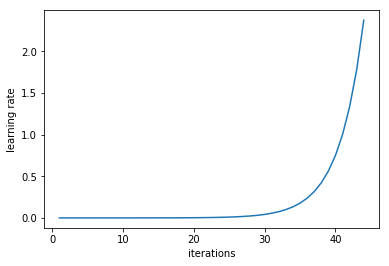

In [6]:
model1000.plot_learning_rate()

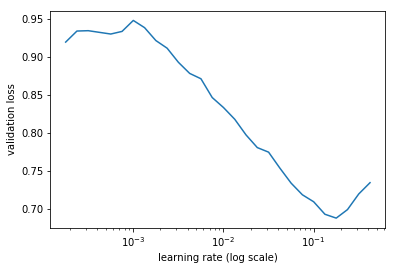

In [7]:
model1000.plot_learning_rate_schedule()

In [8]:
lr = 0.01

Train last layer from precomputed activations for 1-2 epochs

In [9]:
model1000.fit(lr)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.425641   0.251865   0.911243  
    1      0.348075   0.221472   0.920118                                                                              



Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with
cycle_len=1

In [10]:
model1000.set_precompute(False)

In [11]:
model1000.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.264393   0.223425   0.908284  
    1      0.258707   0.199745   0.920118                                                                              
    2      0.258582   0.207272   0.923077                                                                              



Unfreeze all layers

In [12]:
model1000.learn.unfreeze()

In [13]:
model1000.learning_rate_finder()

 88%|██████████████████████████████████████████████████████████████▏        | 42/48 [01:40<00:14,  2.38s/it, loss=1.52]

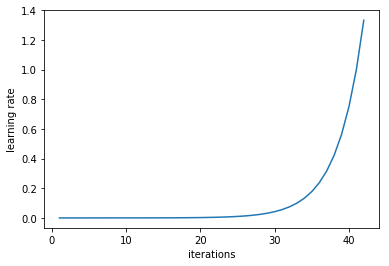

In [14]:
model1000.plot_learning_rate()

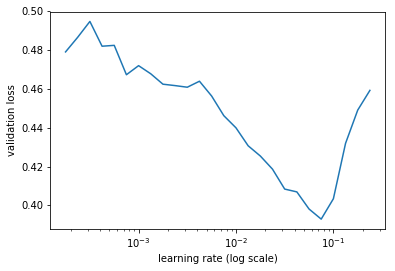

In [15]:
model1000.plot_learning_rate_schedule()

Set earlier layers to 3x-10x lower learning rate than next higher layer

In [16]:
lr = bc.np.array([1e-4,1e-3,1e-2])

Use lr_find() again

Train full network with cycle_mult=2 until over-fitting

In [17]:
model1000.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.303069   0.206647   0.926036  
    1      0.232553   0.192242   0.926036                                                                              
    2      0.170153   0.18277    0.926036                                                                              
    3      0.139707   0.163699   0.93787                                                                               
    4      0.111282   0.143293   0.952663                                                                              
    5      0.086435   0.151099   0.940828                                                                              
    6      0.086748   0.157906   0.943787                                                                              


In [18]:
model1000.learn.save("model1000")


In [125]:
#http://forums.fast.ai/t/how-do-we-use-our-model-against-a-specific-image/7661/3
trn_tfms, val_tfms = model1000.tfms

In [127]:
single_file = bc.path(PATH+"/train/").dirs()[0].files()[0]
im = val_tfms(bc.open_image(single_file))
print(im.shape)

(3, 224, 224)


In [126]:
single_file = bc.path(PATH+"/train/").dirs()[0].files()[0]
im = val_tfms(bc.open_image(single_file))
log_preds = model1000.learn.predict_array(im[None])
preds = bc.np.exp(log_preds)

In [104]:
bc.np.argmax(preds)

0

In [105]:
single_file = bc.path(PATH+"/train/").dirs()[1].files()[0]
im = val_tfms(bc.open_image(single_file))
log_preds = model1000.learn.predict_array(im[None])
preds = bc.np.exp(log_preds)

In [106]:
bc.np.argmax(preds)

1

In [94]:
preds

array([[0.99267, 0.00733]], dtype=float32)

In [123]:
pred_dir = "" #Directory with images to predict
dest0 = "d:/results/0"
dest1 = "d:/results/1"

In [117]:
pred_files = bc.path(pred_dir).files()
for f in pred_files:
    try:
        bc.open_image(f)
    except Exception:
        f.remove()
pred_files = bc.path(pred_dir).files()
ds = bc.FilesIndexArrayDataset(pred_files, bc.np.zeros(len(pred_files)), val_tfms, PATH)
dl = bc.DataLoader(ds)
log_preds = model1000.learn.predict_dl(dl)
preds = bc.np.exp(log_preds)

In [120]:
results = bc.np.argmax(preds, axis=1)

In [124]:
for i in range(0, len(results)):
    if results[i] == 0:
        pred_files[i].copy(dest0)
    else:
        pred_files[i].copy(dest1)